In [1]:
# Auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

# Hyperparameter Tuning

### 1) Load preprocessed training data

In [49]:
training_file = './data/train_preprocessed_impute.csv'
df = pd.read_csv(training_file)

num_records, num_attributes = df.shape
print("There are {} data points in training data, each with {} attributes.". format(num_records, num_attributes))

There are 24415 data points in training data, each with 34 attributes.


### 2) Use the selected features for hyperparameter tunning for `n_estimators`, `max_depth`, `learning_rate`

In [ ]:
X = df.drop(columns=['price'])
y = df['price']

selected_columns = [
    'make',
    'model',
    'type_of_vehicle',
    'engine_cap',
    'no_of_owners',
    'depreciation',
    'power',
    'road_tax',
    'mileage',
    'omv_arf_ratio',
    'dereg_coe_ratio',
    'car_age',
    'omv',
    'arf',
    'coe car',
    'parf car',
    'low mileage car'
]

X_selected = X[selected_columns]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

param_grid = {
    # 'n_estimators': [50, 100, 200, 300, 500],
    # 'max_depth': [3, 4, 5, 6, 8],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.05],
}

best_params = None
best_score = float('inf')

rmse_valid_scores = []
rmse_train_scores = []

for params in ParameterGrid(param_grid):
    regressor = GradientBoostingRegressor(random_state=42, **params)
    
    scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
    
    rmse_train = scores['train_score'] * (-1)
    rmse_valid = scores['test_score'] * (-1)
    
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(params, np.mean(rmse_train), np.std(rmse_train), np.mean(rmse_valid), np.std(rmse_valid)))

    rmse_valid_mean = np.mean(rmse_valid)
    rmse_valid_scores.append(rmse_valid_mean)
    if rmse_valid_mean < best_score:
        best_score = rmse_valid_mean
        best_params = params

    rmse_train_mean = np.mean(rmse_train)
    rmse_train_scores.append(rmse_train_mean)

print("Best parameters:", best_params)
print("Best RMSE from cross-validation:", best_score)

param = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}, RSME training = 10541.4 (135.9), RSME validation = 18876.7 (1909.1)
param = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}, RSME training = 7299.6 (76.4), RSME validation = 17822.8 (3078.3)
param = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}, RSME training = 5449.8 (89.4), RSME validation = 18475.3 (3371.3)
param = {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}, RSME training = 4055.3 (95.1), RSME validation = 20123.7 (3569.6)
param = {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500}, RSME training = 2102.3 (45.8), RSME validation = 21757.9 (6373.3)
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}
Best RMSE from cross-validation: 17822.813986088146


### 3) Plot the model performance diagram

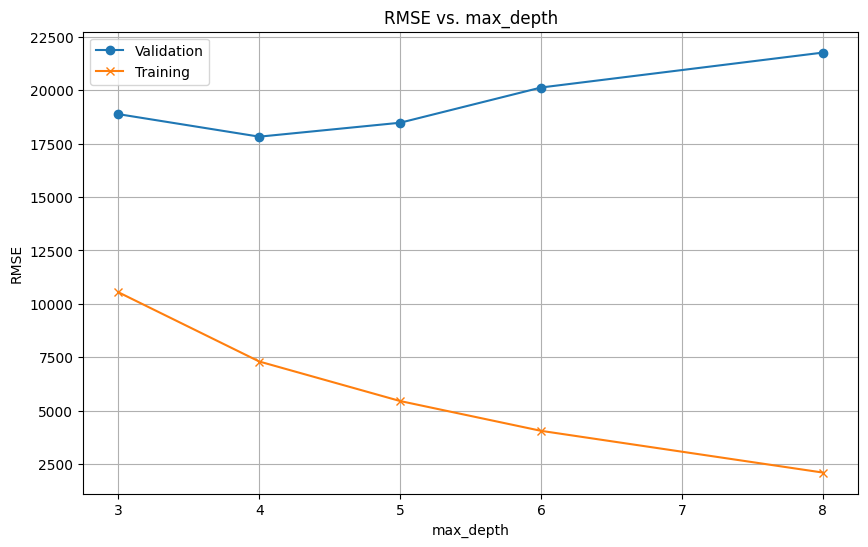

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(param_grid['max_depth'], rmse_valid_scores, marker='o')
plt.plot(param_grid['max_depth'], rmse_train_scores, marker='x')
plt.legend(['Validation', 'Training'])
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('RMSE vs. max_depth')
plt.grid(True)
plt.show()

### 4) Evaluate the performance with the optimal hyperparameters from the previous fine-tuning step

In [61]:
best_model = GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=4)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error on test set:", rmse)

Root Mean Squared Error on test set: 16223.758808579409


### 5) Load the preprocessed test dataset

In [ ]:
test_file = './data/test_preprocessed.csv'
df_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0'])

num_records, num_attributes = df_test.shape
print("There are {} data points in test data, each with {} attributes.". format(num_records, num_attributes))

There are 10000 data points in test data, each with 33 attributes.


### 6) Predict using the model with the optimal hyperparameters from the previous fine-tuning step

In [ ]:
selected_columns = [
    'make',
    'model',
    'type_of_vehicle',
    'engine_cap',
    'no_of_owners',
    'depreciation',
    'power',
    'road_tax',
    'mileage',
    'omv_arf_ratio',
    'dereg_coe_ratio',
    'car_age',
    'omv',
    'arf',
    'coe car',
    'parf car',
    'low mileage car'
]

X_test_selected = df_test[selected_columns]
best_model = GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=4)
best_model.fit(X_selected, y)

y_pred = best_model.predict(X_test_selected)

predictions_df = pd.DataFrame({
    'Id': df_test.index,
    'Predicted': y_pred
})

predictions_df.to_csv('./data/gbr_result.csv', index=False)
print("Prediction file 'gbr_result.csv' generated successfully.")

# Feature Selection Exploration

### 1) Load preprocessed training and test dataset

In [5]:
training_file = './data/train_preprocessed_impute.csv'
df = pd.read_csv(training_file)

test_file = './data/test_preprocessed.csv'
df_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0'])

### 1) Use SelectFromModel to select important features

In [4]:
X = df.drop(columns=['price'])
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_selector = GradientBoostingRegressor()
feature_selector.fit(X_scaled, y)

selector = SelectFromModel(feature_selector, threshold="median")
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

print("Selected features:", selected_features)

Selected features: Index(['model', 'manufactured', 'power', 'depreciation', 'coe', 'road_tax',
       'dereg_value', 'mileage', 'omv', 'arf', 'reg_year', 'car_age',
       'coe car', 'parf car', 'rare & exotic', 'omv_arf_ratio',
       'dereg_coe_ratio'],
      dtype='object')


### 2) Use RFE to select the best features for the model with the best hyperparameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=4)

rfe = RFE(estimator=regressor)
rmse_scores = []
n_features_list = list(range(1, X_train.shape[1] + 1))

for n_features in n_features_list:
    rfe.n_features_to_select = n_features
    scores = cross_val_score(rfe, X_train, y_train, cv=6, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-np.mean(scores))
    print(f"n_features = {n_features}, RMSE = {-np.mean(scores)}")

optimal_n_features = n_features_list[np.argmin(rmse_scores)]
print(f"Optimal number of features: {optimal_n_features}")
print(f"Best RMSE score: {min(rmse_scores)}")


### 3) Evaluate the best hyperparameters and features on the unseen evaluation dataset.

In [ ]:
rfe_fit = deepcopy(rfe)
rfe.n_features_to_select = optimal_n_features
rfe_fit.fit(X_train, y_train)

In [ ]:
X_train_selected = X_train.iloc[:, rfe_fit.get_support()]
X_test_selected = X_test.iloc[:, rfe_fit.get_support()]

best_model = GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=4)
best_model.fit(X_train_selected, y_train)

y_pred = best_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error on test set:", rmse)

Root Mean Squared Error on test set: 18455.11256253101


### 4) Predict using GBR with selected hyperparameter and features from the previous fine-tuning step

In [ ]:
regressor = GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=4)
regressor.fit(X.iloc[:, rfe_fit.get_support()], y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200,
                          random_state=42)

In [ ]:
y_pred = regressor.predict(df_test.iloc[:, rfe_fit.get_support()])

predictions_df = pd.DataFrame({
    'Id': df_test.index,
    'Predicted': y_pred
})

predictions_df.to_csv('./data/gbr_result_features.csv', index=False)